# Tracking the genealogy during forward simulation

This tutorial will cover several use cases of `tskit` for forward simulations.  We start with a simple Wright-Fisher simulation with no selection and no recomination, and gradually increase the complexity of our examples until we are recording mutations, ancient samples, and associated meta-data.

The code used here is written in Python3.  However, the logic will apply to a simulation written in any language where `tskit` is used for simplification.

## Conventions used

The following markups will appear in this document.  They represent some of the "wisdom" accumulated when writing and debugging simulations using `tskit/msprime`.

**Pro tip:** refers to an advanced concept to keep in mind when developing/testing your own simulations.

**Detail:** refers to a technical detail about implementation choices made here.  These details may or may not be general.

**Gotcha:** refers to something non-intuitive that can lead to subtle bugs.

A sub-section titled "Technical notes" will contain long-winded **Pro tip** entries.  Please feel free to skip these during a first reading.

A sub-section titled "Gory details" will attempt to unpack a complex piece of code.  Usually, this will be a discussion of implementation details that have to do with corner cases of stochastic simulations.  These can probably be skipped be skipped by most readers most of the time but will hopefully be useful to someone.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from IPython.display import SVG
import msprime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import namedtuple
import pickle

In [2]:
msprime.__version__

'0.5.0b3.dev10+g1296d0a'

## Definitions

Before we can make any progress, we require a few definitions.  We will focus on the case of diploids, but the concepts used here generalize to any ploidy. Actually, things generalize to any mixtures of ploidys if you are willing to do the book-keeping!

A *node* is used to label the birth time of a lineage.  A node can be described by a tuple, `(id, time)`, where `id` is unique and `time` reflects the birth time of that `id`. A *diploid* is a pair of nodes.

For the case of the discrete-time Wright-Fisher (WF) model, if $N$ individuals currently exist at time point $t$, then there are $2N$ nodes, $[i,i+2N)$, and the diploids are defined as tuples grouping pairs of adjacent nodes, $D \in [(i,i+1),(i+2,i+3),\dots,(2N-2,2N-1)]$, where each $(i,j)$ pairing is a diploid.

An *edge* reflects a transmission event between nodes.  An edge is a tuple `(left, right, parent, child)` whose meaning is "Parent $P$ passed on the genomic interval $[l,r)$ to child $C$".

The goal of this tutorial is to work through the book-keeping required to generate nodes and edges forwards in time and "simplify" them into the minimal set of nodes and edges that describe the history of the sample.

All of our simulations will follow the parameter scaling laid out by Dick Hudson's `ms` software, which is also used in `mspms`, a command-line script that is part of [msprime](https://github.com/jeromekelleher/msprime).

We also need to define what we mean by time, which is simple for the discrete-time model.  A simulation will start at generation 0, which consists of $2N$ parental nodes (nodes $[0,2N)$) and no edges. We will simulate forwards in time for $g$ generations, starting with $g = 1$ (the first offspring generation).  In generation $g$, we will add nodes with `id` values $[2Ng,2N(g+1))$ and `time` value $g$ to the `NodeTable`.

The simplification algorithm works with respect to a *sample*.  Here, a sample will refer to the most recent generation simulated *plus* any ancient samples that are being tracked.

## A Wright-Fisher simulation with no recombination

Here, we simulate a constant-sized Wright-Fisher population of $N$ _diploid_ individuals with no mutation, no recombination, and no selection.  We generate nodes and edges as we go and simplify once at the end.

The mechanics of transmission in this case are simple.  Each generation simply adds $2N$ more nodes to a `NodeTable` and $2N$ edges to an `EdgeTable` (one for each paretal gamete).  In the absence of recombination, an offspring inherits the interval $[0,1)$ from each of two parental nodes.  To generate an offspring, we pick two parents, and then one node from each parent, and create edges reflecting the transmission.

The simulation is shown in the following function:

In [3]:
def wf1(N, ngens):
    """
    Constant-sized WF model with no mutation, no recombination, no selection,
    and no simplification.
    """
    nodes, edges = msprime.NodeTable(), msprime.EdgeTable()
    
    # Add 2N nodes at time = 0.
    # These nodes represent the 
    # initial list of parental
    # gametes
    for i in range(2*N):
        nodes.add_row(time=0)
    
    next_offspring_index = len(nodes)
    first_parental_index = 0
    for gen in range(1,ngens+1):
        assert(next_offspring_index == len(nodes))
        assert(first_parental_index == len(nodes) - 2*N)
        # Pick 2N parents
        parents = np.random.randint(0, N, 2*N)
        for parent1, parent2 in zip(parents[::2], parents[1::2]):
            # Pick 1 gamete from each parent
            mendel = np.random.random_sample(2)
            g1 = first_parental_index + 2*parent1 + (mendel[0] < 0.5)
            g2 = first_parental_index + 2*parent2 + (mendel[1] < 0.5)

            # Add nodes for our offspring's
            # two gametes
            nodes.add_row(time=float(gen))
            nodes.add_row(time=float(gen))
  
            # Add edges reflecting the
            # transmission from parental
            # nodes to offspring nodes
            edges.add_row(left=0.0, right=1.0, parent=g1, child=next_offspring_index)
            edges.add_row(left=0.0, right=1.0, parent=g2, child=next_offspring_index+1)
            
            next_offspring_index += 2
            
        first_parental_index += 2*N
        
    return (nodes,edges)

Let's run the simulation, simulating 100 diploids for 1,000 generations:

In [4]:
np.random.seed(42)
nodes, edges = wf1(100,1000)

### Simplifying the output

First, we have to convert time from forwards to backwards, and reset the node table accordingly.

**Detail:** We also set the "flags" to 1 for each node, marking it as a sample.

In [5]:
t = nodes.time
t -= t.max()
t *= -1.0
flags = np.ones(len(nodes),dtype=np.uint32)
nodes.set_columns(time=t,flags=flags)

Our "samples" will be all nodes from the last generation simulated, which is now the nodes with `time` equal to 0.0.

In [6]:
samples=np.where(nodes.time == 0.0)[0]

We are now ready to sort, simplify, and load tables:

In [7]:
msprime.sort_tables(nodes=nodes,edges=edges)
node_map = msprime.simplify_tables(samples=samples.tolist(),nodes=nodes,edges=edges)
ts = msprime.load_tables(nodes=nodes,edges=edges)

Let's take a look at the result:

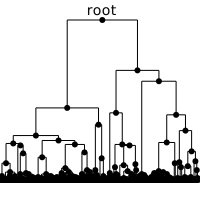

In [8]:
SVG(next(ts.trees()).draw(height=200,width=200, node_labels={len(ts.tables.nodes)-1:'root'}))

The `node_map` returned from the simplify function is the same length as our input (un-simplified) node table.  Each element has a value of -1 if the input node is not an output node (e.g., it was "simplified out" of the final data), otherwise it contains the index of the node in the simplified node table.  Let's look at the relationship between the indexes for the final generation before and after simplification:

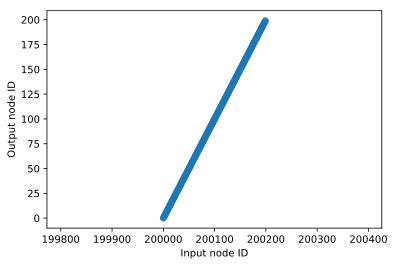

In [9]:
p = sns.regplot(x=samples,y=node_map[samples],fit_reg=False)
p.set(xlabel="Input node ID",ylabel="Output node ID");

The above figure is quite important: when we simplify with respect to the *last* generation simulated, those nodes become the *first* nodes in the simplified tables!  The reason is because our simplified tables represent time from the present to the past.  The implication is that our simple book-keeping of `next_offspring_index` and `first_parental_index` will be less simple when we apply the simplification step *during* a forward simulation instead of once at the end.

**Pro tip:** note the perfectly linear relationship betwee input node id and output node id in the above figure.  The simplification algorithm *preserves input order of sample nodes*, which is something we'll need to keep in mind later when handling ancient samples.

## Adding regular simplification

Here, we implement the WF simulation with simplification happening at regular intervals.  It is helpful to think of this as regular "garbage collection", as what we're really doing is getting rid of extinct lineages while also "trimming" extant lineages down to a minimal representation.

**Gotcha:** Regular garbage collection forces us to reckon with the figure from the previous section, which shows us that simplification remaps the input sample IDs to `[0,len(samples))`.  This remapping affects how we update the values of *both* `next_offspring_index` and `next_parental_index`.  See the comments in the implementation below.

First, we need to move our simplification code into a separate scope, as we call it from multiple points of our simulation:

In [10]:
def simplify_nodes_edges(nodes,edges,temp_nodes,dt):
    """
    :param nodes (msprime.NodeTable): All nodes simplified so far
    :param edges (msprime.EdgeTable): All edges simplified so far
    :param temp_nodes (msprime.NodeTable): All new nodes since the last simplification happened.
    :param dt (int): The number of generations since the last simplification
    
    :rtype: None
    """
    if len(edges) == 0:
        # This is a guard for the case of simplifying every generation.
        # This function will be called when generation the first
        # set of offspring, at which point the edges will be empty,
        # and attempting to simplify empty EdgeTables results
        # in an exception
        return nodes,edges
    
    # "Push" existing nodes dt generations further back into the past:
    nodes.set_columns(time=nodes.time+float(dt),flags=nodes.flags)
    
    # Reverse direction of time for our new nodes:
    t = temp_nodes.time
    t -= t.max()
    t *= -1.0
    
    # Append new nodes to old nodes, sort, simplify:
    nodes.append_columns(time=t,flags=np.ones(len(temp_nodes),dtype=np.uint32))
    msprime.sort_tables(nodes=nodes,edges=edges)
    samples = np.where(nodes.time == 0.0)[0]
    node_map = msprime.simplify_tables(samples=samples.tolist(),nodes=nodes,edges=edges)
    
    # Assert that the plot shown in the previous section always holds true.
    assert(all(node_map[samples] == np.arange(len(samples),dtype=node_map.dtype)))


Our new simulation will return a tuple of *simplified* nodes and edges:

In [11]:
def wf2(N, ngens, gc):
    """
    Constant-sized WF model with no mutation, no recombination, no selection,
    and no simplification.
    
    :param N (int): Diploid population size
    :param ngens (int): Number of generations to simulate
    :param gc (int): "Garbage collection" interval, or how often to simplify the data.
    
    :rtype: tuple
    
    :returns: A simplified tuple, (msprime.NodeTable, msprime.EdgeTable)
    """
    if gc < 1:
        raise ValueError("gc must be a non-negative int")
        
    nodes, edges = msprime.NodeTable(), msprime.EdgeTable()
    temp_nodes = msprime.NodeTable()
    # Add 2N nodes at time = 0.
    # These nodes represent the 
    # initial list of parental
    # gametes
    for i in range(2*N):
        nodes.add_row(time=0)
    
    next_offspring_index = len(nodes)
    first_parental_index = 0
    last_gc_time = 0
    for gen in range(1,ngens+1):
        if (gen) % gc == 0.0:
            # Simplify the data
            simplify_nodes_edges(nodes,edges,temp_nodes,gen-last_gc_time)
            last_gc_time=gen
            
            # Empty out our temp node table
            temp_nodes.reset()
            
            # len(nodes) has been changed by simplification.
            # Node ids are [0,len(nodes)), implying
            # the following value for the next offspring
            # index:
            next_offspring_index = len(nodes)
            
            # The node ids from the last generation simulated
            # have been remapped to start at 0, which is the 
            # value of the first valid parent:
            first_parental_index = 0
            assert(all(nodes.time[:2*N] == 0.0))
        else:
            # If we have NOT simplified the data, 
            # then we have appended 2N new nodes to the end of
            # temp_nodes.  Thus, the last 2N nodes are the potential
            # parents of the next generation.  Since
            # next_offspring_index is set to the correct value,
            # we can simply use that as our baseline:
            first_parental_index = next_offspring_index - 2*N
            
            # The following may be useful to know. len(nodes)
            # is the current length of all simplified nodes so far.
            # len(temp_nodes) is the length of any new nodes added
            # since the last simplification.  Thus, the sum of the
            # two NodeTables gives a second way to calculate
            # first_parental_index:
            assert(first_parental_index == len(nodes)+len(temp_nodes)-2*N)
            
        # Pick 2N parents
        parents = np.random.randint(0, N, 2*N)
        for parent1, parent2 in zip(parents[::2], parents[1::2]):
            # Pick 1 gamete from each parent
            mendel = np.random.random_sample(2)
            g1 = first_parental_index + 2*parent1 + (mendel[0] < 0.5)
            g2 = first_parental_index + 2*parent2 + (mendel[1] < 0.5)

            # Add nodes for our offspring's
            # two gametes
            temp_nodes.add_row(time=float(gen))
            temp_nodes.add_row(time=float(gen))
  
            # Add edges reflecting the
            # transmission from parental
            # nodes to offspring nodes
            edges.add_row(left=0.0, right=1.0, parent=g1, child=next_offspring_index)
            edges.add_row(left=0.0, right=1.0, parent=g2, child=next_offspring_index + 1)
            
            next_offspring_index += 2

    if len(temp_nodes)>0:
        # Handle any new nodes before returning
        simplify_nodes_edges(nodes, edges, temp_nodes, gen + 1 - last_gc_time)

    return (nodes,edges)

### Invariance to simplification interval

A critical concept to keep in mind is that the simulation itself is the only random component.  The simplification algorithm is deterministic *given a set of (nodes, edges) satisfying msprime/tskit's sorting requirements*.

Therefore, the results of our `wf2` function must be the same for all simplification intervals:

In [12]:
np.random.seed(42)
n, e = wf2(100,1000, 1)

# Iterate over a range of 
# odd and even simplification
# intervals.
for i in range(2,1000,33):
    # Make sure each new sim
    # starts with same random seed!
    np.random.seed(42)
    ni, ei = wf2(100, 1000, i)
    assert(n == ni)
    assert(e == ei)

**Pro tip**: testing your own code using loops like the one above is a very good way to identify subtle bugs in book-keeping.

**Detail:** the results of `wf1` will *not* be the identical to those from `wf2` because our book-keeping of parent/offspring indexes differs.  Results over many simulation replicates will be the same *in distribution*, however.

**Gotcha:** The book-keeping of `first_parental_index` is still rather simple here due to keeping $N$ constant.  Arbitrary variation in $N$ over time doesn't change any of the concepts, but it does force you to do some more book-keeping.

### Summary

* Simplifying during a simulation changes the rules for how we generate new node IDs and track the parent/offspring node ID relationship.

* When simplifying regularly, we need to "push" existing simplified nodes further back in time.

* Our code to simplify NodeTable and EdgeTable instances gets called in two different parts of our simulation.  When we're in that situation, we should offload the work to a class or function for easier code re-use and for testing.

#### Technical notes

* We have found that it is possible to write a simulation where the results differ by simplification interval, but appear correct in distribution.  By this we mean that looking at distributions of numbers of mutations, their frequencies, etc., match predictions from analytical theory.  However, our experience is that such simulations contain bugs and that the summaries being used for testing are too crude to catch them.  For example, they may affect the variance in a subtle way that would require millions of simulations to catch.  Often what is going on is that parent/offspring relationships are not being properly recorded, resulting in lineages that either persist too long or not long enough.  (In other words, the variance in offspring number per diploid is no longer what it should be, meaning you've changed the effective population size.) Thus, please make sure you get the **same** NodeTable and EdgeTable out of a simulation for any simplification interval.

## Adding mutation and recombination
   
In this section, we will add mutation and recombination to our simulation.  Mutations will occur according to the infinitely-many sites model, which means that a new mutation cannot arise at a currently-mutated position.  We will model recombination as a uniform Poisson process along a genomic interval. The relevant parameters are:

* $\theta = 4N\mu$ is the scaled mutation rate, and is equal to twice the expected number of new mutations per generation.  The parameter $\mu$ is the expected number of new mutations per gamete, per generation.

* $\rho = 4Nr$ is the scaled recombination rate. The parameter $r$ is the expected number of recombination breakpoints per diploid per meiosis.

Mutation positions and recombination breakpoints will be uniformly distributed along the continuous interval $[0,1)$.

**Detail:** regarding recombination, we need to define the following requirements, which are primarily technical:

* A recombination breakpoint with value $x$ implies a crossover between position $x$ and $x+\delta x$, where $\delta x$ is the difference between $x$ and the next floating point value $> x$, moving in the direction away from zero.  Thus, $x = 0$ effectively means that parent gametes $i$ and $j$ are swapped, and that this swapping differs from what we've done above and called "Mendel".  We require this definition because our genomic interval is $[0,1)$ and we will be generating breakpoints according to a uniform process on the same continuous interval. By analogy to a discrete model of recombination between "nucleotides", this definition is equivalent to saying that a crossover at position $x$ occurs *between* positions $x$ and $x+1$, where $x$ is any integer in the discrete interval $[0,1,2,\ldots,L)$, where $L$ is the length of the region in base pairs. The "gory details" section below provides a concrete example of this definition in action.

Recombination and mutation change the complexity of the simulation quite a bit:

* We must now add to and simplify msprime.SiteTable and msprime.MutationTable instances
* `msprime/tskit` have the ability to associate metadata with mutations.  The metadata is encoded as raw bytes, allowing you to write down anything you want.   Here, we will record the origin time of each mutation and its position.
* Matings no longer result in two offspring edges.  Rather, each parent contributes $1+r$ edges on average to each offspring.

We will write mutation and recombination functions here which we will re-use in future examples.  The big-picture view of what we want to accomplish is the following:

* For the first parent, recombine its two gametes and assign the resulting edges to a new node in an offspring.
* Generate mutations and assign them to this new node. (Mutations are associated initially with the first node on which they appear!)
* Repeat these two steps for the second parent.

**Detail:** we will be treating mutations as neutral.  Doing so is odd, as one big selling point of `tskit` is the ability to skip the tracking of neutral mutations in forward simulations.  However, tracking neutral mutations plus metadata is the same as tracking selected mutations and their metadata, and being able to do neat things like put your selected mutations onto a figure of the genealogy is one of several possible use cases.

In [13]:
def infsites(mu, lookup):
    """
    :param mu (float): Mutation rate (per gamete, per generation)
    :param lookup (dict): The currently segregating positions in the population.
    
    :rtype: np.array
    
    :returns: Positions of new mutations.
    """
    nmut = np.random.poisson(mu)
    if nmut == 0:
        return np.empty([0], dtype=np.float64)
    i = 0
    rv = np.zeros(nmut)
    while i < nmut:
        pos = np.random.random_sample(1)
        while pos[0] in lookup:
            pos = np.random.random_sample(1)
        rv[i] = pos[0]
        lookup[rv[i]] = True
        i += 1
    return rv

In [14]:
def poisson_recombination(r, parent_indexes, next_offspring_id, edges):
    """
    :param r (float): Recombination rate (mean of a Poisson)
    :param parent_indexes (tuple): The two parental nodes
    :param next_offspring_id (int): The current value of next_offspring_id in the simulation
    :param edges (msprime.EdgeTable): The edge table for the simulation
    """
    
    nbreaks = np.random.poisson(r)
    if nbreaks == 0:
        # The parent passes the entire region onto the child
        edges.add_row(left=0.0,right=1.0,
                      parent=parent_indexes[0],
                      child=next_offspring_id)
    else:
        b = []
        i = 0
        while i < nbreaks:
            p = np.random.random_sample(1)
            while p[0] in b:
                p = np.random.random_sample(1)
            b.append(p[0])
            i += 1
        # Sort, so that adjacent values represent
        # genomic segments
        b.sort()
        # np.random.sample generates a uniform deviate
        # on [0,1), so we need to "cap" our segments
        # with a 1:
        b.append(1.0)

        # Handle the technical requirement 
        # described above
        if b[0] != 0.0:
            b.insert(0,0.0)
        else:
            parent_indexes = (parent_indexes[1], parent_indexes[0])
        
        # Create a list of parent gamete indexes of sufficient length
        # such that we can co-iterate it along with the breakpoints
        pgams = list([*tuple(i for i in parent_indexes)]*int(len(b)/2))

        # Add new offspring edges via Python "fancy" indexing
        for l,r,p in zip(b[0:len(b)-1],b[1:len(b)],pgams):
            edges.add_row(left=l,
                         right=r,
                         parent=p,
                         child=next_offspring_id)

#### Gory details

Much of `poisson_recombination` is devoted to setting up the boundaries of the genomic intervals (segments) that will be passed on from parent to child.  What we need to do is understand how these boundaries are transmitted as edges.

Let's say we that the following are the parental nodes:

In [15]:
pnodes = (163, 162)

Further, let's assume we have the following breakpoints:

In [16]:
brk = [0.25, 0.75]

The contents of `brk` in words mean:

* Interval $[0,0.25)$ is passed from 163 to child
* Interval $[0.25, 0.75)$ is passed from 162 to child
* Interval $[0.75, 1.)$ is passed from 163 to child

In order to make that happen, we'll 'cap' our breakpoints with 0 and 1:

In [17]:
brk.append(1.0)
brk.insert(0,0.0)
print(brk)

[0.0, 0.25, 0.75, 1.0]


Now, we can zip everything together to generate our new edges:

In [18]:
pg=list([*tuple(i for i in pnodes)]*int(len(brk)/2))
print('Parent nodes are:',pg)
print('Left end of segments are',brk)
for l,r,p in zip(brk[:len(brk)-1],brk[1:len(brk)],pg):
    print('left =',l,'right =',r,'parent =',p)

Parent nodes are: [163, 162, 163, 162]
Left end of segments are [0.0, 0.25, 0.75, 1.0]
left = 0.0 right = 0.25 parent = 163
left = 0.25 right = 0.75 parent = 162
left = 0.75 right = 1.0 parent = 163


If, however, our breakpoints contained a zero:

In [19]:
brk = [0,0.25,0.75]

Our verbal description becomes:

* $[0,0.25)$ passed from 162 to child
* $[0.25,0.75)$ passed from 163 to child
* $[0.75,1)$ passed from 162 to child

To make this work, we simply need to reverse the input parent node IDs and run the same machinery:

In [20]:
brk.append(1.0)
pg=list([*tuple(i for i in reversed(pnodes))]*int(len(brk)/2))
print('Parent nodes are:',pg)
print('Left end of segments are',brk)
for l,r,p in zip(brk[:len(brk)-1],brk[1:len(brk)],pg):
    print('left =',l,'right =',r,'parent =',p)

Parent nodes are: [162, 163, 162, 163]
Left end of segments are [0, 0.25, 0.75, 1.0]
left = 0 right = 0.25 parent = 162
left = 0.25 right = 0.75 parent = 163
left = 0.75 right = 1.0 parent = 162


**End of gory details**

In [21]:
def simplify_nodes_edges_mutations(nodes,edges,sites,mutations,temp_nodes,temp_mutations,dt):
    """
    :param nodes (msprime.NodeTable): All nodes simplified so far
    :param edges (msprime.EdgeTable): All edges simplified so far
    :param temp_nodes (msprime.NodeTable): All new nodes since the last simplification happened.
    :param dt (int): The number of generations since the last simplification
    """
    
    # Our first sets of operations are what we've used in 
    # previous examples
    if len(edges) == 0:
        return nodes,edges,sites,mutations
    
    nodes.set_columns(time=nodes.time+float(dt),flags=nodes.flags)
    
    t = temp_nodes.time
    t -= t.max()
    t *= -1.0
 
    nodes.append_columns(time=t,flags=np.ones(len(temp_nodes),dtype=np.uint32))
    samples = np.where(nodes.time == 0.0)[0]
    
    # What we need to do now is add update our site and mutation tables
    
    # First, convert our meta data into raw bytes, which is handled via 
    # Python's built-in pickling:
    encoded, offset = msprime.pack_bytes(list(map(pickle.dumps,[i[1] for i in temp_mutations])))
    
    sites.append_columns(position=[i[1].pos for i in temp_mutations],
                         # encode ancestral state as '0'
                        ancestral_state=np.zeros(len(temp_mutations), np.int8) + ord('0'),
                        ancestral_state_offset=np.arange(len(temp_mutations) + 1, dtype=np.uint32))
    mutations.append_columns(site=np.arange(len(temp_mutations),dtype=np.int32)+len(mutations),
                             node=[i[0] for i in temp_mutations],
                             # encode derived state as '1'
                             derived_state=np.ones(len(temp_mutations),dtype=np.int8)+ord('0'),
                             derived_state_offset=np.arange(len(temp_mutations)+1,dtype=np.uint32),
                             metadata_offset=offset,
                             metadata=encoded)
    
    # Sort and simplify
    msprime.sort_tables(nodes=nodes,edges=edges,sites=sites,mutations=mutations)
    node_map = msprime.simplify_tables(samples=samples.tolist(),
                                       nodes=nodes,edges=edges,
                                       sites=sites,
                                       mutations=mutations)
    assert(all(node_map[samples] == np.arange(len(samples),dtype=node_map.dtype)))
    return nodes,edges,sites,mutations

In [22]:
MutationMetaData = namedtuple('MutationMetaData',['origin','pos'])

def wf3(N, ngens, theta, rho, gc):    
    if gc < 1:
        raise ValueError("gc must be a non-negative int")
        
    nodes, edges = msprime.NodeTable(), msprime.EdgeTable()
    temp_nodes = msprime.NodeTable()
    # We now need to track mutation and site tables
    mutations = msprime.MutationTable()
    sites = msprime.SiteTable()
    # We need a list to track new mutations in between
    # simplification intervals
    temp_mutations = []

    mu = theta/float(4*N)
    r = rho/float(4*N)
    
    for i in range(2*N):
        nodes.add_row(time=0)
    
    next_offspring_index = len(nodes)
    first_parental_index = 0
    last_gc_time = 0
    # We need a hash table 
    # to book-keep our infinite-sites
    # mutation model
    lookup = dict()
    for gen in range(1,ngens+1):
        if (gen) % gc == 0.0:
            simplify_nodes_edges_mutations(nodes,edges,
                                           sites,mutations,
                                           temp_nodes, temp_mutations,
                                           gen-last_gc_time)
            last_gc_time=gen
            temp_mutations.clear()
            temp_nodes.reset()
            lookup = {i:True for i in sites.position}
            next_offspring_index = len(nodes)
            first_parental_index = 0
            assert(all(nodes.time[:2*N] == 0.0))
        else:
            first_parental_index = next_offspring_index - 2*N
            assert(first_parental_index == len(nodes)+len(temp_nodes)-2*N)
            
        parents = np.random.randint(0, N, 2*N)
        for parent1, parent2 in zip(parents[::2], parents[1::2]):
            
            # Record the two node indexes
            # corresponding to each parent.
            # We need them for the mechanics of
            # recombination.
            p1g1 = first_parental_index + 2*parent1
            p1g2 = p1g1+1
            p2g1 = first_parental_index + 2*parent2
            p2g2 = p2g1+1
            
            # Swap parental gametes 50% of the time.
            # This determines which parental gamete
            # is the start of segment transmission to the offspring.
            mendel = np.random.random_sample(2)
            if mendel[0] < 0.5:
                p1g1, p1g2 = p1g2, p1g1
            if mendel[1] < 0.5:
                p2g1, p2g2 = p2g2, p2g1
                
            # Recombine parent 1
            poisson_recombination(r,
                                  (p1g1,p1g2),
                                  next_offspring_index,
                                  edges)
            # Mutate the recombinant gamete
            mpos = infsites(mu,lookup)
            # record node and metadata for 
            # each new mutation
            for mi in mpos:
                temp_mutations.append((next_offspring_index,
                                     MutationMetaData(gen,mi)))
            next_offspring_index += 1
            
            # Repeat operations for parent2 
            poisson_recombination(r,
                                  (p2g1,p2g2),
                                  next_offspring_index,
                                  edges)
            mpos = infsites(mu,lookup)
            for mi in mpos:
                temp_mutations.append((next_offspring_index,
                                     MutationMetaData(gen,mi)))
            next_offspring_index += 1
                

            # Add nodes for our offspring's
            # two gametes
            temp_nodes.add_row(time=float(gen))
            temp_nodes.add_row(time=float(gen))

    if len(temp_nodes)>0:
        # Handle any new nodes before returning
         simplify_nodes_edges_mutations(nodes,edges,
                                        sites,mutations,
                                        temp_nodes,temp_mutations,
                                        gen+1-last_gc_time)

    return (nodes,edges,sites,mutations)

In [23]:
np.random.seed(42)
n, e, s, m = wf3(100,1000,10.0,100.0,10)

Let's test the sensitivity to the GC interval:

In [24]:
for GC in range(1,1000,67):
    np.random.seed(42)
    ni, ei, si, mi = wf3(100,1000,10.0,100.0,GC)
    assert(n == ni)
    assert(e == ei)
    assert(s == si)
    assert(m == mi)

### Comments

* Variation in the mutation process over time/space is a trivial extension of what we've done here.
* Variation in the genetic map is likewise trivial; simply change the function specifying breakpoint locations.
* Mutation metadata could be used to 'flag' mutations as 'amino acid', 'indel', or whatever you'd like.
* Back mutation is trivial (but see technical comment below).  Back mutations are recorded in the mutation table as a reversion of the ancestral state.
* We use `dict` to enforce the infinitely-many sites requirement instead of searching the current `SiteTable` because the former is hashed, meaning constant-time lookups, whereas the best we could to with the `SiteTable` would be log time.

#### Technical notes

Our mutation scheme of continuous mutation positions on a specific interval would require some care in order to properly implement back-mutation.  We will not bother to do so.  However, it is important to realize that it would be incorrect to consider the case where a new draw from `np.random.random_sample` is the same as a currently-existing mutation position as a back mutation.  The reason why this would be an error has to do with the how floating-point values are distributed within specific intervals and how random number generators are implements.  To do models with back mutation correctly:

* Define genomic regions as integers of intervals, $R \in {0, 1, 2, \ldots, L-1}$, where $L$ is the region length.
* Use functions designed to sample from ranges of integers to generate mutation positions.  For example, [`np.random.randint`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.randint.html).

### Summary
* Our simplification function is getting more complex and taking more arguments.  At this point, we'd help ourselves by encapsulating some of this work into a proper class, which we do below.
* `collections.namedtuple` plus pickling is a straightforward method to handle metadata in Python

## Starting with a prior history

In this section we show how to 'seed' a forward simulation with a set of nodes and edges generated from a coalescent simulation.

Let's take a look at how many roots are present in each marginal tree that came out of our simulation with recombination in the previous section:

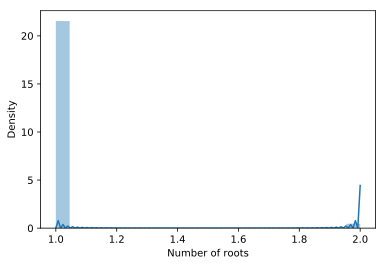

In [25]:
ts = msprime.load_tables(nodes=n,edges=e,sites=s,mutations=m)

nroots=[]
for i in ts.trees():
    nroots.append(i.num_roots)
p = sns.distplot(nroots)
p.set(xlabel="Number of roots",ylabel="Density");

Most of our trees have one root, but a handful have two.  What is happening is that even though we simulated for $10N$ generations, and $E[TMRCA]=4N$, the variance is pretty big, such that some marginal trees are not completely coalesced.  Let's take a look at the distribution of TMRCA using msprime:

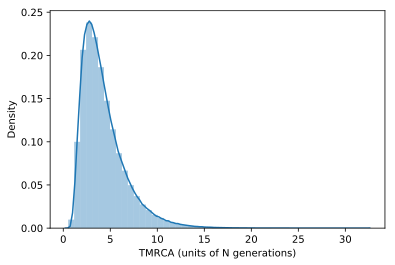

In [26]:
tmrca=[]
sims=msprime.simulate(100,recombination_rate=25.0,random_seed=42,num_replicates=10000)
for sim in sims:
    for marginal in sim.trees():
        tmrca.append(marginal.get_time(marginal.get_root()))
p = sns.distplot(tmrca)
p.set(xlabel="TMRCA (units of N generations)",ylabel="Density");

So, some fraction of marginal trees have *very* large TMRCA! We have two ways to deal with this:

* Run the forward simulations longer. (Boo! Hiss!)
* Start the simulation with a (reasonable) coalescent tree.